In [ ]:
################################################################################################
################################################ PROJECT #######################################
################################################################################################

In [ ]:
################ t-copula for risk-factors ################

In [ ]:
# packages
import yfinance as yf
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, norm
from statsmodels.distributions.copula.api import StudentTCopula
from statsmodels.distributions.copula.copulas import CopulaDistribution
from scipy.stats import t, kurtosis
import math
import xlrd
import scipy as sp
from scipy.optimize import minimize_scalar
from scipy.stats import spearmanr

In [ ]:
# download data for SPX and VIX
#spx_data = yf.download('^GSPC', start='2023-10-10', end='2024-10-10', interval='1d')
#spx_data = yf.download('^SP500TR', start='2023-10-10', end='2024-10-10', interval='1d')
spx_data = yf.download('^SPX', start='2018-03-26', end='2019-03-26', interval='1d')
vix_data = yf.download('^VIX', start='2018-03-26', end='2019-03-26', interval='1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Reset index to get 'Date' as a column
spx_data.reset_index(inplace=True)
vix_data.reset_index(inplace=True)

# Rename columns for clarity
spx_data.rename(columns={'Close': 'SPX_Level'}, inplace=True)
vix_data.rename(columns={'Close': 'VIX_Level'}, inplace=True)

# Merge the two DataFrames on the 'Date' column
df = pd.merge(spx_data[['Date', 'SPX_Level']], vix_data[['Date', 'VIX_Level']], on='Date', how='outer')
df

# df.to_excel('/Users/vasiliinosov/Desktop/George_Mason/5th_semester/Quant_Risk_Management/Assignments/Assignment_3a/assignment3_solution_vasilii_nosov.xlsx', index = False)

Price,Date,SPX_Level,VIX_Level
Ticker,,^SPX,^VIX
0,2018-03-26 00:00:00+00:00,2658.550049,21.030001
1,2018-03-27 00:00:00+00:00,2612.620117,22.500000
2,2018-03-28 00:00:00+00:00,2605.000000,22.870001
3,2018-03-29 00:00:00+00:00,2640.870117,19.969999
4,2018-04-02 00:00:00+00:00,2581.879883,23.620001
...,...,...,...
246,2019-03-19 00:00:00+00:00,2832.570068,13.560000
247,2019-03-20 00:00:00+00:00,2824.229980,13.910000
248,2019-03-21 00:00:00+00:00,2854.879883,13.630000


In [ ]:
# ascending order of date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date', ascending = True)
df

Price,Date,SPX_Level,VIX_Level
Ticker,,^SPX,^VIX
0,2018-03-26 00:00:00+00:00,2658.550049,21.030001
1,2018-03-27 00:00:00+00:00,2612.620117,22.500000
2,2018-03-28 00:00:00+00:00,2605.000000,22.870001
3,2018-03-29 00:00:00+00:00,2640.870117,19.969999
4,2018-04-02 00:00:00+00:00,2581.879883,23.620001
...,...,...,...
246,2019-03-19 00:00:00+00:00,2832.570068,13.560000
247,2019-03-20 00:00:00+00:00,2824.229980,13.910000
248,2019-03-21 00:00:00+00:00,2854.879883,13.630000


In [ ]:
# log returns for SPX and VIX
df['spx_log_returns'] = np.log(df['SPX_Level'] / df['SPX_Level'].shift(1)).dropna()
df['vix_log_returns'] = np.log(df['VIX_Level'] / df['VIX_Level'].shift(1)).dropna()
df

Price,Date,SPX_Level,VIX_Level,spx_log_returns,vix_log_returns
Ticker,,^SPX,^VIX,,
0,2018-03-26 00:00:00+00:00,2658.550049,21.030001,NaN,NaN
1,2018-03-27 00:00:00+00:00,2612.620117,22.500000,-0.017427,0.067565
2,2018-03-28 00:00:00+00:00,2605.000000,22.870001,-0.002921,0.016311
3,2018-03-29 00:00:00+00:00,2640.870117,19.969999,0.013676,-0.135595
4,2018-04-02 00:00:00+00:00,2581.879883,23.620001,-0.022591,0.167863
...,...,...,...,...,...
246,2019-03-19 00:00:00+00:00,2832.570068,13.560000,-0.000131,0.034512
247,2019-03-20 00:00:00+00:00,2824.229980,13.910000,-0.002949,0.025484
248,2019-03-21 00:00:00+00:00,2854.879883,13.630000,0.010794,-0.020335


In [ ]:
# drop first observation
df1 = df.iloc[1:]
df1

Price,Date,SPX_Level,VIX_Level,spx_log_returns,vix_log_returns
Ticker,,^SPX,^VIX,,
1,2018-03-27 00:00:00+00:00,2612.620117,22.500000,-0.017427,0.067565
2,2018-03-28 00:00:00+00:00,2605.000000,22.870001,-0.002921,0.016311
3,2018-03-29 00:00:00+00:00,2640.870117,19.969999,0.013676,-0.135595
4,2018-04-02 00:00:00+00:00,2581.879883,23.620001,-0.022591,0.167863
5,2018-04-03 00:00:00+00:00,2614.449951,21.100000,0.012536,-0.112821
...,...,...,...,...,...
246,2019-03-19 00:00:00+00:00,2832.570068,13.560000,-0.000131,0.034512
247,2019-03-20 00:00:00+00:00,2824.229980,13.910000,-0.002949,0.025484
248,2019-03-21 00:00:00+00:00,2854.879883,13.630000,0.010794,-0.020335


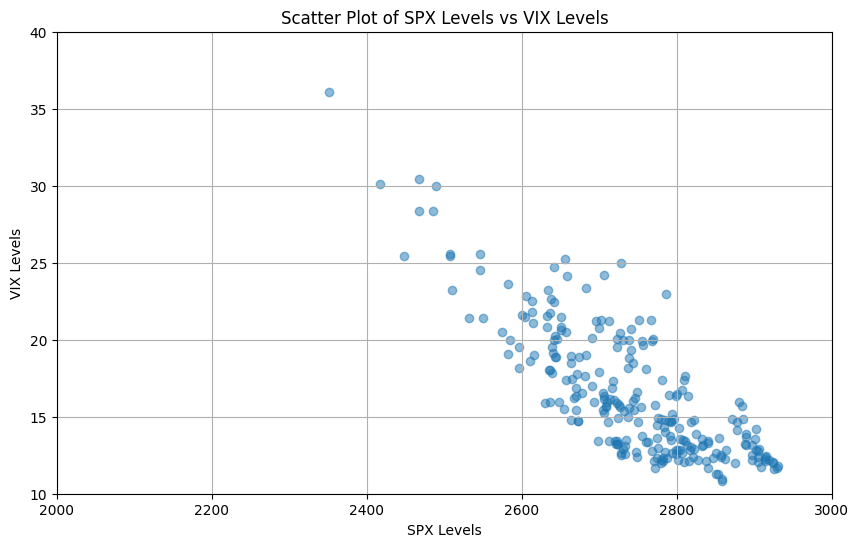

In [ ]:
# scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df1['SPX_Level'], df1['VIX_Level'], alpha=0.5)
plt.title('Scatter Plot of SPX Levels vs VIX Levels')
plt.xlabel('SPX Levels')
plt.ylabel('VIX Levels')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1)

# x-axis limits
plt.xlim(2000, 3000)
plt.ylim(10,40)

plt.grid()
plt.show()

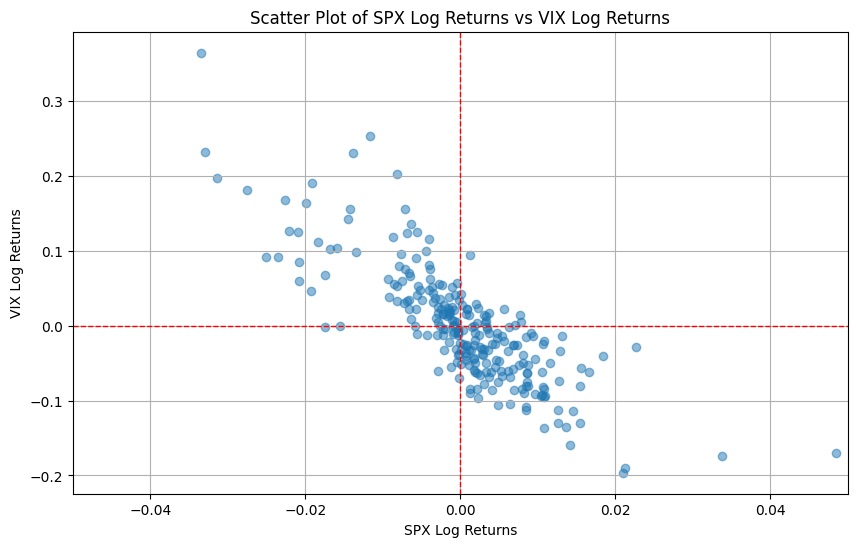

In [ ]:
# scatter plot for log returns
plt.figure(figsize=(10, 6))
plt.scatter(df1['spx_log_returns'], df1['vix_log_returns'], alpha=0.5)
plt.title('Scatter Plot of SPX Log Returns vs VIX Log Returns')
plt.xlabel('SPX Log Returns')
plt.ylabel('VIX Log Returns')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1)

# x-axis limits
plt.xlim(-0.05, 0.05)

plt.grid()
plt.show()


In [ ]:
df1 = df1.copy()

# Calculate the rank columns
df1['SPX Rank'] = df1['spx_log_returns'].rank()
df1['VIX Rank'] = df1['vix_log_returns'].rank()

df1

Price,Date,SPX_Level,VIX_Level,spx_log_returns,vix_log_returns,SPX Rank,VIX Rank
Ticker,,^SPX,^VIX,,,,
1,2018-03-27 00:00:00+00:00,2612.620117,22.500000,-0.017427,0.067565,17.0,214.0
2,2018-03-28 00:00:00+00:00,2605.000000,22.870001,-0.002921,0.016311,70.0,164.0
3,2018-03-29 00:00:00+00:00,2640.870117,19.969999,0.013676,-0.135595,238.0,7.0
4,2018-04-02 00:00:00+00:00,2581.879883,23.620001,-0.022591,0.167863,7.0,242.0
5,2018-04-03 00:00:00+00:00,2614.449951,21.100000,0.012536,-0.112821,233.0,12.0
...,...,...,...,...,...,...,...
246,2019-03-19 00:00:00+00:00,2832.570068,13.560000,-0.000131,0.034512,116.0,189.0
247,2019-03-20 00:00:00+00:00,2824.229980,13.910000,-0.002949,0.025484,69.0,179.0
248,2019-03-21 00:00:00+00:00,2854.879883,13.630000,0.010794,-0.020335,229.0,106.0


In [ ]:
# make eCDF
n = len(df1)

df1.loc[:, 'SPX eCDF'] = df1['SPX Rank'] / (n + 1)
df1.loc[:, 'VIX eCDF'] = df1['VIX Rank'] / (n + 1)
df1

Price,Date,SPX_Level,VIX_Level,spx_log_returns,vix_log_returns,SPX Rank,VIX Rank,SPX eCDF,VIX eCDF
Ticker,,^SPX,^VIX,,,,,,
1,2018-03-27 00:00:00+00:00,2612.620117,22.500000,-0.017427,0.067565,17.0,214.0,0.067729,0.852590
2,2018-03-28 00:00:00+00:00,2605.000000,22.870001,-0.002921,0.016311,70.0,164.0,0.278884,0.653386
3,2018-03-29 00:00:00+00:00,2640.870117,19.969999,0.013676,-0.135595,238.0,7.0,0.948207,0.027888
4,2018-04-02 00:00:00+00:00,2581.879883,23.620001,-0.022591,0.167863,7.0,242.0,0.027888,0.964143
5,2018-04-03 00:00:00+00:00,2614.449951,21.100000,0.012536,-0.112821,233.0,12.0,0.928287,0.047809
...,...,...,...,...,...,...,...,...,...
246,2019-03-19 00:00:00+00:00,2832.570068,13.560000,-0.000131,0.034512,116.0,189.0,0.462151,0.752988
247,2019-03-20 00:00:00+00:00,2824.229980,13.910000,-0.002949,0.025484,69.0,179.0,0.274900,0.713147
248,2019-03-21 00:00:00+00:00,2854.879883,13.630000,0.010794,-0.020335,229.0,106.0,0.912351,0.422311


In [ ]:
# calculate mean and st.d. for SPX and VIX log returns
mean_spx = df1['spx_log_returns'].mean()
std_spx = df1['spx_log_returns'].std()
mean_vix = df1['vix_log_returns'].mean()
std_vix = df1['vix_log_returns'].std()
print("mean spx", mean_spx)
print("std spx", std_spx)
print("mean vix", mean_vix)
print("std vix", std_vix)

mean spx 0.00020501075974059164
std spx 0.009917774510449007
mean vix -0.0010117844802200234
std vix 0.07812056500547722


In [ ]:
# transform eCDFs into normal distribution
df1.loc[:, 'SPX Normal'] = stats.norm.ppf(df1['SPX eCDF'], loc=mean_spx, scale=std_spx)
df1.loc[:, 'VIX Normal'] = stats.norm.ppf(df1['VIX eCDF'], loc=mean_vix, scale=std_vix)
df1


Price,Date,SPX_Level,VIX_Level,spx_log_returns,vix_log_returns,SPX Rank,VIX Rank,SPX eCDF,VIX eCDF,SPX Normal,VIX Normal
Ticker,,^SPX,^VIX,,,,,,,,
1,2018-03-27 00:00:00+00:00,2612.620117,22.500000,-0.017427,0.067565,17.0,214.0,0.067729,0.852590,-0.014601,0.080828
2,2018-03-28 00:00:00+00:00,2605.000000,22.870001,-0.002921,0.016311,70.0,164.0,0.278884,0.653386,-0.005608,0.029805
3,2018-03-29 00:00:00+00:00,2640.870117,19.969999,0.013676,-0.135595,238.0,7.0,0.948207,0.027888,0.016348,-0.150439
4,2018-04-02 00:00:00+00:00,2581.879883,23.620001,-0.022591,0.167863,7.0,242.0,0.027888,0.964143,-0.018765,0.139678
5,2018-04-03 00:00:00+00:00,2614.449951,21.100000,0.012536,-0.112821,233.0,12.0,0.928287,0.047809,0.014716,-0.131198
...,...,...,...,...,...,...,...,...,...,...,...
246,2019-03-19 00:00:00+00:00,2832.570068,13.560000,-0.000131,0.034512,116.0,189.0,0.462151,0.752988,-0.000737,0.052417
247,2019-03-20 00:00:00+00:00,2824.229980,13.910000,-0.002949,0.025484,69.0,179.0,0.274900,0.713147,-0.005726,0.042939
248,2019-03-21 00:00:00+00:00,2854.879883,13.630000,0.010794,-0.020335,229.0,106.0,0.912351,0.422311,0.013647,-0.016322


In [ ]:
# new df for eCDFs and transformed normal values
df2 = df1[['SPX eCDF', 'VIX eCDF', 'SPX Normal', 'VIX Normal']]
df2

Price,SPX eCDF,VIX eCDF,SPX Normal,VIX Normal
Ticker,,,,
1,0.067729,0.852590,-0.014601,0.080828
2,0.278884,0.653386,-0.005608,0.029805
3,0.948207,0.027888,0.016348,-0.150439
4,0.027888,0.964143,-0.018765,0.139678
5,0.928287,0.047809,0.014716,-0.131198
...,...,...,...,...
246,0.462151,0.752988,-0.000737,0.052417
247,0.274900,0.713147,-0.005726,0.042939
248,0.912351,0.422311,0.013647,-0.016322


In [ ]:
# excess kurtosis for SPX and VIX log returns
excess_kurt_spx = kurtosis(df1['spx_log_returns'], bias=False)
excess_kurt_vix = kurtosis(df1['vix_log_returns'], bias=False)
print("excess_kurt_spx", excess_kurt_spx)
print("excess_kurt_vix", excess_kurt_vix)

excess_kurt_spx 3.4692010703970633
excess_kurt_vix 2.3240618632328998


In [ ]:
# degrees of freedom for SPX and VIX log returns
df_spx = (6 / excess_kurt_spx) + 4
df_vix = (6 / excess_kurt_vix) + 4
print("df_spx", df_spx)
print("df_vix", df_vix)

df_spx 5.729504827840168
df_vix 6.581686871129009


In [ ]:
# tau
tau_spx = np.sqrt((df_spx-2)/df_spx)*std_spx
tau_vix = np.sqrt((df_vix-2)/df_vix)*std_vix
print("tau_spx", tau_spx)
print("tau_vix", tau_vix)

tau_spx 0.008001681708282712
tau_vix 0.06517926663545787


In [ ]:
# student's t eCDF using the inverse of the Student's t distribution
df2 = df2.copy()

df2.loc[:, 'SPX t Inv'] = stats.t.ppf(df1['SPX eCDF'], df=df_spx) * tau_spx + mean_spx
df2.loc[:, 'VIX t Inv'] = stats.t.ppf(df1['VIX eCDF'], df=df_vix) * tau_vix + mean_vix

df2 = df2[['SPX eCDF', 'VIX eCDF', 'SPX Normal', 'VIX Normal', 'SPX t Inv', 'VIX t Inv']]
df2

Price,SPX eCDF,VIX eCDF,SPX Normal,VIX Normal,SPX t Inv,VIX t Inv
Ticker,,,,,,
1,0.067729,0.852590,-0.014601,0.080828,-0.013691,0.073166
2,0.278884,0.653386,-0.005608,0.029805,-0.004773,0.025861
3,0.948207,0.027888,0.016348,-0.150439,0.015679,-0.152159
4,0.027888,0.964143,-0.018765,0.139678,-0.018941,0.138725
5,0.928287,0.047809,0.014716,-0.131198,0.013764,-0.127721
...,...,...,...,...,...,...
246,0.462151,0.752988,-0.000737,0.052417,-0.000589,0.046174
247,0.274900,0.713147,-0.005726,0.042939,-0.004878,0.037565
248,0.912351,0.422311,0.013647,-0.016322,0.012578,-0.014299


In [ ]:
df2['SPX Log Returns'] = df1['spx_log_returns']
df2['VIX Log Returns'] = df1['vix_log_returns']
df2.head()

Price,SPX eCDF,VIX eCDF,SPX Normal,VIX Normal,SPX t Inv,VIX t Inv,SPX Log Returns,VIX Log Returns
Ticker,,,,,,,,
1,0.067729,0.852590,-0.014601,0.080828,-0.013691,0.073166,-0.017427,0.067565
2,0.278884,0.653386,-0.005608,0.029805,-0.004773,0.025861,-0.002921,0.016311
3,0.948207,0.027888,0.016348,-0.150439,0.015679,-0.152159,0.013676,-0.135595
4,0.027888,0.964143,-0.018765,0.139678,-0.018941,0.138725,-0.022591,0.167863
5,0.928287,0.047809,0.014716,-0.131198,0.013764,-0.127721,0.012536,-0.112821


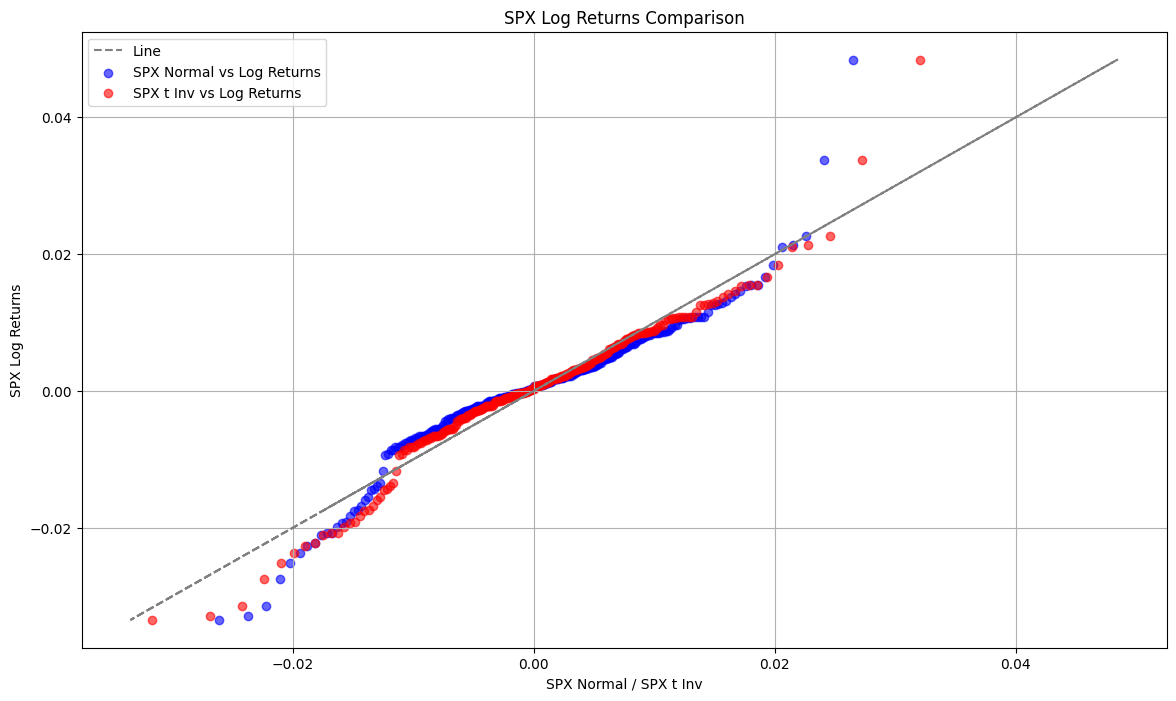

In [ ]:
# scatter plot for SPX
plt.figure(figsize=(14, 8))
# SPX Log Returns vs SPX Log Returns (line)
plt.plot(df2['SPX Log Returns'], df2['SPX Log Returns'], color='gray', linestyle='--', label='Line')
# SPX Normal vs SPX Log Returns
plt.scatter(df2['SPX Normal'], df2['SPX Log Returns'], color='blue', alpha=0.6, label='SPX Normal vs Log Returns')
# SPX t Inv vs SPX Log Returns
plt.scatter(df2['SPX t Inv'], df2['SPX Log Returns'], color='red', alpha=0.6, label='SPX t Inv vs Log Returns')

plt.title('SPX Log Returns Comparison')
plt.xlabel('SPX Normal / SPX t Inv')
plt.ylabel('SPX Log Returns')
plt.legend()
plt.grid()

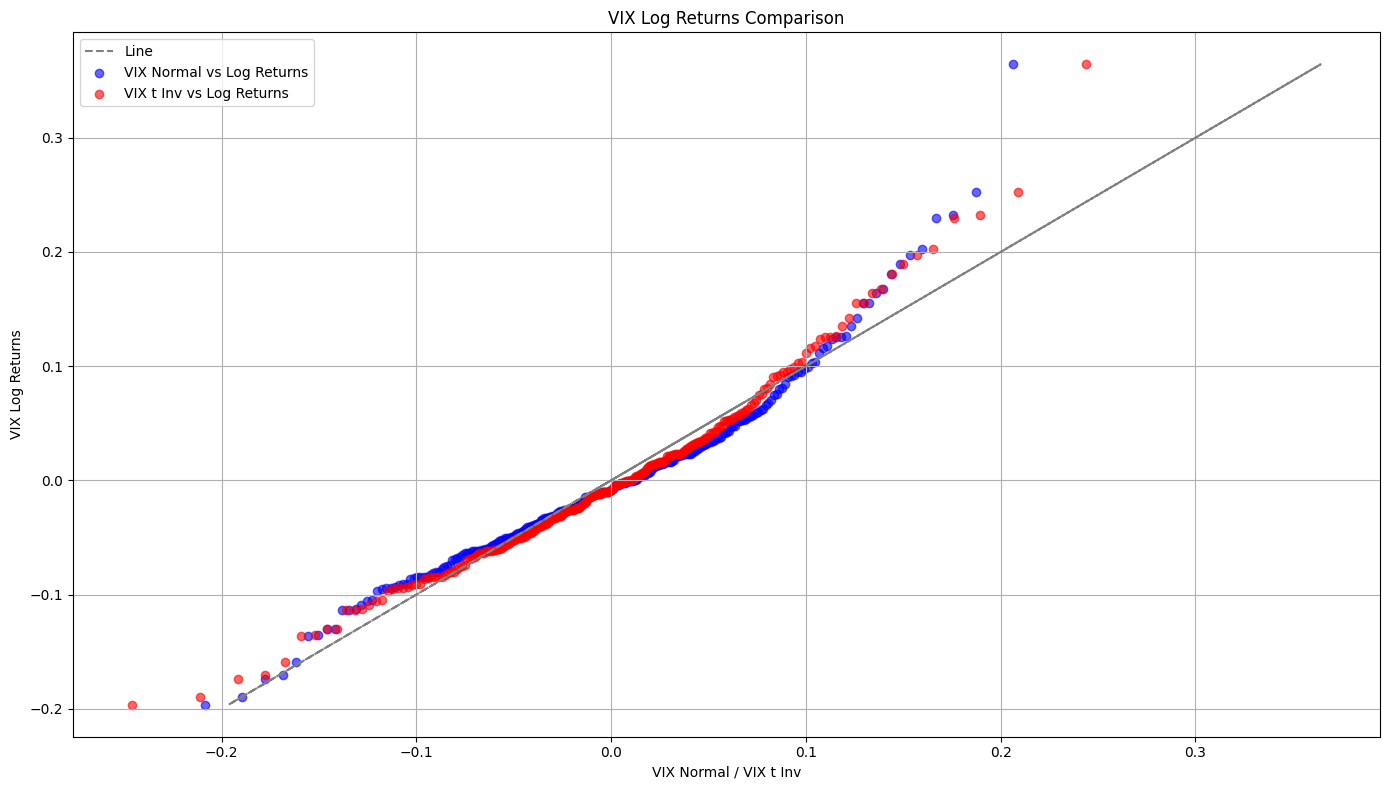

In [ ]:
# scatter plot for VIX
plt.figure(figsize=(14, 8))
# VIX Log Returns vs VIX Log Returns (line)
plt.plot(df2['VIX Log Returns'], df2['VIX Log Returns'], color='gray', linestyle='--', label='Line')
# VIX Normal vs VIX Log Returns
plt.scatter(df2['VIX Normal'], df2['VIX Log Returns'], color='blue', alpha=0.6, label='VIX Normal vs Log Returns')
# VIX t Inv vs VIX Log Returns
plt.scatter(df2['VIX t Inv'], df2['VIX Log Returns'], color='red', alpha=0.6, label='VIX t Inv vs Log Returns')

plt.title('VIX Log Returns Comparison')
plt.xlabel('VIX Normal / VIX t Inv')
plt.ylabel('VIX Log Returns')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# correlation

correlation = df1['spx_log_returns'].corr(df1['vix_log_returns'])
correlation

-0.8172068992885864

In [ ]:
# spearman rho

rho, p_value = stats.spearmanr(df1['spx_log_returns'], df1['vix_log_returns'])
print(f"Spearman's rho: {rho}")
print(f"P-value: {p_value}")

Spearman's rho: -0.8239001584025344
P-value: 4.2250023794428516e-63


In [ ]:
# copula rho

copula_rho = 2 * math.sin(math.pi * rho / 6)
copula_rho

-0.8362733810944644

In [ ]:
# cholesky upper matrix

cholesky_matrix = np.array([[1, copula_rho],
                             [0, np.sqrt(1 - copula_rho**2)]])
cholesky_matrix

array([[ 1.        , -0.83627338],
       [ 0.        ,  0.54831271]])

In [ ]:
# generate standard normal random numbers

np.random.seed(42)

data = np.random.normal(loc=0, scale=1, size=(1000, 2))
df2 = pd.DataFrame(data, columns=['Z1', 'Z2'])

# df2.to_excel('/Users/vasiliinosov/Desktop/George_Mason/5th_semester/Quant_Risk_Management/project/z_table.xlsx', index = False)
df2

,Z1,Z2
0,0.496714,-0.138264
1,0.647689,1.523030
2,-0.234153,-0.234137
3,1.579213,0.767435
4,-0.469474,0.542560
...,...,...
995,0.800410,0.754291
996,1.188913,0.708304
997,0.351448,1.070150
998,-0.026521,-0.881875


In [ ]:
# z columns correlation

corr_z1z2 = df2['Z1'].corr(df2['Z2'])
var_z1 = df2['Z1'].var()
var_z2 = df2['Z2'].var()
print("correlation", corr_z1z2)
print("var_z1", var_z1)
print("var_z2", var_z2)

correlation 0.0025841511632257175
var_z1 0.9246809989831687
var_z2 1.0301423489775727


In [ ]:
matrix_z1z2 = df2[['Z1', 'Z2']].to_numpy()
matrix_z1z2

array([[ 0.49671415, -0.1382643 ],
       [ 0.64768854,  1.52302986],
       [-0.23415337, -0.23413696],
       ...,
       [ 0.35144821,  1.07015024],
       [-0.02652126, -0.88187465],
       [-0.16306696, -0.74490264]])

In [ ]:
correl_st_normal = np.dot(matrix_z1z2, cholesky_matrix)
correl_st_normal

array([[ 0.49671415, -0.4912009 ],
       [ 0.64768854,  0.29345195],
       [-0.23415337,  0.06743596],
       ...,
       [ 0.35144821,  0.2928702 ],
       [-0.02652126, -0.46136406],
       [-0.16306696, -0.27207103]])

In [ ]:
# correlated St Norm

correl_st_normal = pd.DataFrame(correl_st_normal, columns=['norm_SPX', 'norm_VIX'])
correl_st_normal

,norm_SPX,norm_VIX
0,0.496714,-0.491201
1,0.647689,0.293452
2,-0.234153,0.067436
3,1.579213,-0.899859
4,-0.469474,0.690102
...,...,...
995,0.800410,-0.255774
996,1.188913,-0.605885
997,0.351448,0.292870
998,-0.026521,-0.461364


In [ ]:
# concatenate df

simulation = pd.concat([df2[['Z1', 'Z2']], correl_st_normal[['norm_SPX', 'norm_VIX']]], axis=1)
simulation

,Z1,Z2,norm_SPX,norm_VIX
0,0.496714,-0.138264,0.496714,-0.491201
1,0.647689,1.523030,0.647689,0.293452
2,-0.234153,-0.234137,-0.234153,0.067436
3,1.579213,0.767435,1.579213,-0.899859
4,-0.469474,0.542560,-0.469474,0.690102
...,...,...,...,...
995,0.800410,0.754291,0.800410,-0.255774
996,1.188913,0.708304,1.188913,-0.605885
997,0.351448,1.070150,0.351448,0.292870
998,-0.026521,-0.881875,-0.026521,-0.461364


In [ ]:
# simulated MV Normal SPX and VIX

simulation['mv_norm_SPX'] = mean_spx + std_spx * simulation['norm_SPX']
simulation['mv_norm_VIX'] = mean_vix + std_vix * simulation['norm_VIX']
simulation

,Z1,Z2,norm_SPX,norm_VIX,mv_norm_SPX,mv_norm_VIX
0,0.496714,-0.138264,0.496714,-0.491201,0.005131,-0.039385
1,0.647689,1.523030,0.647689,0.293452,0.006629,0.021913
2,-0.234153,-0.234137,-0.234153,0.067436,-0.002117,0.004256
3,1.579213,0.767435,1.579213,-0.899859,0.015867,-0.071309
4,-0.469474,0.542560,-0.469474,0.690102,-0.004451,0.052899
...,...,...,...,...,...,...
995,0.800410,0.754291,0.800410,-0.255774,0.008143,-0.020993
996,1.188913,0.708304,1.188913,-0.605885,0.011996,-0.048344
997,0.351448,1.070150,0.351448,0.292870,0.003691,0.021867
998,-0.026521,-0.881875,-0.026521,-0.461364,-0.000058,-0.037054


In [ ]:
# simulated uniform SPX and VIX

simulation['uniform_SPX'] = norm.cdf(simulation['norm_SPX'])
simulation['uniform_VIX'] = norm.cdf(simulation['norm_VIX'])
simulation

,Z1,Z2,norm_SPX,norm_VIX,mv_norm_SPX,mv_norm_VIX,uniform_SPX,uniform_VIX
0,0.496714,-0.138264,0.496714,-0.491201,0.005131,-0.039385,0.690305,0.311642
1,0.647689,1.523030,0.647689,0.293452,0.006629,0.021913,0.741407,0.615412
2,-0.234153,-0.234137,-0.234153,0.067436,-0.002117,0.004256,0.407433,0.526883
3,1.579213,0.767435,1.579213,-0.899859,0.015867,-0.071309,0.942856,0.184098
4,-0.469474,0.542560,-0.469474,0.690102,-0.004451,0.052899,0.319365,0.754935
...,...,...,...,...,...,...,...,...
995,0.800410,0.754291,0.800410,-0.255774,0.008143,-0.020993,0.788263,0.399063
996,1.188913,0.708304,1.188913,-0.605885,0.011996,-0.048344,0.882763,0.272296
997,0.351448,1.070150,0.351448,0.292870,0.003691,0.021867,0.637374,0.615189
998,-0.026521,-0.881875,-0.026521,-0.461364,-0.000058,-0.037054,0.489421,0.322269


In [ ]:
# simulated diff LN (norm copula with t margins)

simulation['diff_ln_SPX'] = mean_spx + tau_spx * t.ppf(simulation['uniform_SPX'], df_spx)
simulation['diff_ln_VIX'] = mean_vix + tau_vix * t.ppf(simulation['uniform_VIX'], df_vix)
simulation

,Z1,Z2,norm_SPX,norm_VIX,mv_norm_SPX,mv_norm_VIX,uniform_SPX,uniform_VIX,diff_ln_SPX,diff_ln_VIX
0,0.496714,-0.138264,0.496714,-0.491201,0.005131,-0.039385,0.690305,0.311642,0.004404,-0.034590
1,0.647689,1.523030,0.647689,0.293452,0.006629,0.021913,0.741407,0.615412,0.005726,0.018922
2,-0.234153,-0.234137,-0.234153,0.067436,-0.002117,0.004256,0.407433,0.526883,-0.001757,0.003554
3,1.579213,0.767435,1.579213,-0.899859,0.015867,-0.071309,0.942856,0.184098,0.015101,-0.063974
4,-0.469474,0.542560,-0.469474,0.690102,-0.004451,0.052899,0.319365,0.754935,-0.003759,0.046617
...,...,...,...,...,...,...,...,...,...,...
995,0.800410,0.754291,0.800410,-0.255774,0.008143,-0.020993,0.788263,0.399063,0.007100,-0.018372
996,1.188913,0.708304,1.188913,-0.605885,0.011996,-0.048344,0.882763,0.272296,0.010835,-0.042642
997,0.351448,1.070150,0.351448,0.292870,0.003691,0.021867,0.637374,0.615189,0.003159,0.018882
998,-0.026521,-0.881875,-0.026521,-0.461364,-0.000058,-0.037054,0.489421,0.322269,-0.000017,-0.032513


In [ ]:
# last day of observed data

last_day = '2019-03-25'
last_spx_level = df.loc[df['Date'] == last_day, 'SPX_Level'].values[0]
last_vix_level = df.loc[df['Date'] == last_day, 'VIX_Level'].values[0]

In [ ]:
# simulated levels for SPX and VIX

simulation['SPX_Level'] = last_spx_level * np.exp(simulation['diff_ln_SPX'])
simulation['VIX_Level'] = last_vix_level * np.exp(simulation['diff_ln_VIX'])
simulation

,Z1,Z2,norm_SPX,norm_VIX,mv_norm_SPX,mv_norm_VIX,uniform_SPX,uniform_VIX,diff_ln_SPX,diff_ln_VIX,SPX_Level,VIX_Level
0,0.496714,-0.138264,0.496714,-0.491201,0.005131,-0.039385,0.690305,0.311642,0.004404,-0.034590,2810.712296,15.774810
1,0.647689,1.523030,0.647689,0.293452,0.006629,0.021913,0.741407,0.615412,0.005726,0.018922,2814.428592,16.641942
2,-0.234153,-0.234137,-0.234153,0.067436,-0.002117,0.004256,0.407433,0.526883,-0.001757,0.003554,2793.448290,16.388140
3,1.579213,0.767435,1.579213,-0.899859,0.015867,-0.071309,0.942856,0.184098,0.015101,-0.063974,2840.938102,15.318023
4,-0.469474,0.542560,-0.469474,0.690102,-0.004451,0.052899,0.319365,0.754935,-0.003759,0.046617,2787.860457,17.109274
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.800410,0.754291,0.800410,-0.255774,0.008143,-0.020993,0.788263,0.399063,0.007100,-0.018372,2818.297999,16.032728
996,1.188913,0.708304,1.188913,-0.605885,0.011996,-0.048344,0.882763,0.272296,0.010835,-0.042642,2828.845817,15.648295
997,0.351448,1.070150,0.351448,0.292870,0.003691,0.021867,0.637374,0.615189,0.003159,0.018882,2807.214262,16.641279
998,-0.026521,-0.881875,-0.026521,-0.461364,-0.000058,-0.037054,0.489421,0.322269,-0.000017,-0.032513,2798.313575,15.807593


Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


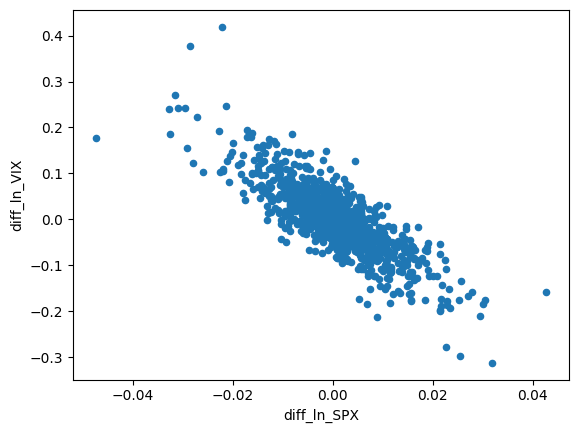

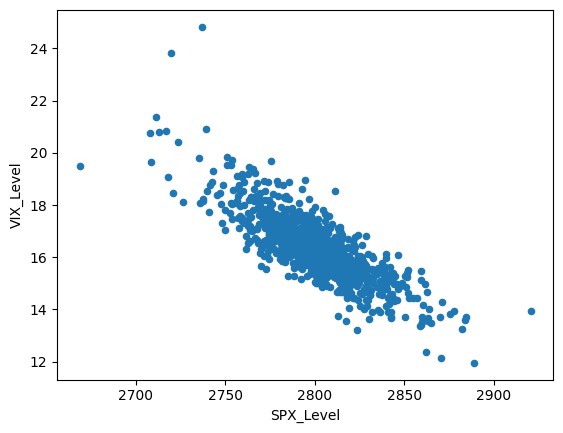

In [ ]:
print(simulation.plot.scatter(x='diff_ln_SPX', y='diff_ln_VIX'))
print(simulation.plot.scatter(x='SPX_Level', y='VIX_Level'))
# simulation.to_excel('/Users/vasiliinosov/Desktop/George_Mason/5th_semester/Quant_Risk_Management/project/simulation_returns.xlsx', index = False)

In [ ]:
################ portfolio ################

In [ ]:
portfolio = pd.DataFrame({
    'holdings': [100, -200, 100],
    'strike': [195, 200, 205],
})
portfolio

,holdings,strike
0,100,195
1,-200,200
2,100,205


In [ ]:
portfolio['date'] = pd.to_datetime('2019-03-26')
portfolio['expiration_date'] = pd.to_datetime('2019-04-18')
portfolio['days_to_expiration'] = (portfolio['expiration_date'] - portfolio['date']).dt.days.astype(int)
portfolio

,holdings,strike,date,expiration_date,days_to_expiration
0,100,195,2019-03-26,2019-04-18,23
1,-200,200,2019-03-26,2019-04-18,23
2,100,205,2019-03-26,2019-04-18,23


In [ ]:
portfolio['rate'] = 0.0245
portfolio

,holdings,strike,date,expiration_date,days_to_expiration,rate
0,100,195,2019-03-26,2019-04-18,23,0.0245
1,-200,200,2019-03-26,2019-04-18,23,0.0245
2,100,205,2019-03-26,2019-04-18,23,0.0245


In [ ]:
portfolio['implied_volatility'] = pd.DataFrame([0.1665, 0.1634, 0.1447])
portfolio

,holdings,strike,date,expiration_date,days_to_expiration,rate,implied_volatility
0,100,195,2019-03-26,2019-04-18,23,0.0245,0.1665
1,-200,200,2019-03-26,2019-04-18,23,0.0245,0.1634
2,100,205,2019-03-26,2019-04-18,23,0.0245,0.1447


In [ ]:
portfolio['underlying_price'] = 200.62
portfolio

,holdings,strike,date,expiration_date,days_to_expiration,rate,implied_volatility,underlying_price
0,100,195,2019-03-26,2019-04-18,23,0.0245,0.1665,200.62
1,-200,200,2019-03-26,2019-04-18,23,0.0245,0.1634,200.62
2,100,205,2019-03-26,2019-04-18,23,0.0245,0.1447,200.62


In [ ]:
portfolio['time'] = (portfolio['days_to_expiration']/365)
portfolio['rt'] = (portfolio['time']*portfolio['rate'])
portfolio['sigma_sqr_t'] = ((portfolio['implied_volatility']**2)*portfolio['time'])
portfolio

,holdings,strike,date,expiration_date,days_to_expiration,rate,implied_volatility,underlying_price,time,rt,sigma_sqr_t
0,100,195,2019-03-26,2019-04-18,23,0.0245,0.1665,200.62,0.063014,0.001544,0.001747
1,-200,200,2019-03-26,2019-04-18,23,0.0245,0.1634,200.62,0.063014,0.001544,0.001682
2,100,205,2019-03-26,2019-04-18,23,0.0245,0.1447,200.62,0.063014,0.001544,0.001319


In [ ]:
portfolio = portfolio.assign(
    d1=lambda df: (
        (np.log(df['underlying_price'] / df['strike']) +
         (df['rate'] + ((df['implied_volatility']**2) / 2)) * df['time']
        ) / (df['implied_volatility'] * np.sqrt(df['time']))
    )
)
portfolio

,holdings,strike,date,expiration_date,days_to_expiration,rate,implied_volatility,underlying_price,time,rt,sigma_sqr_t,d1
0,100,195,2019-03-26,2019-04-18,23,0.0245,0.1665,200.62,0.063014,0.001544,0.001747,0.737642
1,-200,200,2019-03-26,2019-04-18,23,0.0245,0.1634,200.62,0.063014,0.001544,0.001682,0.133608
2,100,205,2019-03-26,2019-04-18,23,0.0245,0.1447,200.62,0.063014,0.001544,0.001319,-0.533923


In [ ]:
portfolio['d2'] = portfolio['d1']-portfolio['implied_volatility']*np.sqrt(portfolio['time'])
portfolio

,holdings,strike,date,expiration_date,days_to_expiration,rate,implied_volatility,underlying_price,time,rt,sigma_sqr_t,d1,d2
0,100,195,2019-03-26,2019-04-18,23,0.0245,0.1665,200.62,0.063014,0.001544,0.001747,0.737642,0.695847
1,-200,200,2019-03-26,2019-04-18,23,0.0245,0.1634,200.62,0.063014,0.001544,0.001682,0.133608,0.092590
2,100,205,2019-03-26,2019-04-18,23,0.0245,0.1447,200.62,0.063014,0.001544,0.001319,-0.533923,-0.570246


In [ ]:
portfolio['norm_d1'] = norm.cdf(portfolio['d1'])
portfolio['norm_d2'] = norm.cdf(portfolio['d2'])
portfolio

,holdings,strike,date,expiration_date,days_to_expiration,rate,implied_volatility,underlying_price,time,rt,sigma_sqr_t,d1,d2,norm_d1,norm_d2
0,100,195,2019-03-26,2019-04-18,23,0.0245,0.1665,200.62,0.063014,0.001544,0.001747,0.737642,0.695847,0.769634,0.756738
1,-200,200,2019-03-26,2019-04-18,23,0.0245,0.1634,200.62,0.063014,0.001544,0.001682,0.133608,0.092590,0.553144,0.536885
2,100,205,2019-03-26,2019-04-18,23,0.0245,0.1447,200.62,0.063014,0.001544,0.001319,-0.533923,-0.570246,0.296697,0.284255


In [ ]:
portfolio = portfolio.assign(
    price=lambda df: (
        df['underlying_price']*df['norm_d1']-df['strike']*np.exp((-1)*df['rt'])*df['norm_d2']
    )
)
portfolio['total'] = portfolio['holdings']*portfolio['price']
portfolio

,holdings,strike,date,expiration_date,days_to_expiration,rate,implied_volatility,underlying_price,time,rt,sigma_sqr_t,d1,d2,norm_d1,norm_d2,price,total
0,100,195,2019-03-26,2019-04-18,23,0.0245,0.1665,200.62,0.063014,0.001544,0.001747,0.737642,0.695847,0.769634,0.756738,7.067806,706.780597
1,-200,200,2019-03-26,2019-04-18,23,0.0245,0.1634,200.62,0.063014,0.001544,0.001682,0.133608,0.092590,0.553144,0.536885,3.760230,-752.045958
2,100,205,2019-03-26,2019-04-18,23,0.0245,0.1447,200.62,0.063014,0.001544,0.001319,-0.533923,-0.570246,0.296697,0.284255,1.340989,134.098856


In [ ]:
### TOTAL VALUE ###
total_market_value = portfolio['total'].sum() + 20
print(total_market_value)

108.83349543994115


In [ ]:
###

In [ ]:
bs = simulation[['diff_ln_SPX', 'diff_ln_VIX']].copy()
bs

,diff_ln_SPX,diff_ln_VIX
0,0.004404,-0.034590
1,0.005726,0.018922
2,-0.001757,0.003554
3,0.015101,-0.063974
4,-0.003759,0.046617
...,...,...
995,0.007100,-0.018372
996,0.010835,-0.042642
997,0.003159,0.018882
998,-0.000017,-0.032513


In [ ]:
### strike 195 ###

In [ ]:
strike_195 = portfolio[portfolio['strike'] == 195].copy()
strike_195

,holdings,strike,date,expiration_date,days_to_expiration,rate,implied_volatility,underlying_price,time,rt,sigma_sqr_t,d1,d2,norm_d1,norm_d2,price,total
0,100,195,2019-03-26,2019-04-18,23,0.0245,0.1665,200.62,0.063014,0.001544,0.001747,0.737642,0.695847,0.769634,0.756738,7.067806,706.780597


In [ ]:
bs_195 = pd.DataFrame()
bs_195['S_0'] = np.exp(bs['diff_ln_SPX'])*strike_195['underlying_price'].values[0]
bs_195['volatility'] = np.exp(bs['diff_ln_VIX'])*strike_195['implied_volatility'].values[0]
bs_195['time'] = strike_195['time'].values[0]
bs_195['sigma_sqr_t'] = (bs_195['volatility']**2)*bs_195['time']
bs_195

,S_0,volatility,time,sigma_sqr_t
0,201.505553,0.160839,0.063014,0.001630
1,201.771982,0.169681,0.063014,0.001814
2,200.267862,0.167093,0.063014,0.001759
3,203.672501,0.156182,0.063014,0.001537
4,199.867259,0.174445,0.063014,0.001918
...,...,...,...,...
995,202.049387,0.163469,0.063014,0.001684
996,202.805581,0.159549,0.063014,0.001604
997,201.254772,0.169674,0.063014,0.001814
998,200.616664,0.161174,0.063014,0.001637


In [ ]:
bs_195 = bs_195.assign(
    d1=lambda df: (
        (np.log(df['S_0'] / strike_195['strike'].values[0]) +
         (strike_195['rate'].values[0] + ((df['volatility']**2) / 2)) * df['time']
        ) / (df['volatility'] * np.sqrt(df['time']))
    ),
    d2 = lambda df: (
        df['d1']-df['volatility']*np.sqrt(df['time'])
    ),
    norm_d1 = lambda df: (
        norm.cdf(df['d1'])
    ),
    norm_d2 = lambda df: (
        norm.cdf(df['d2'])
    )
)
bs_195

,S_0,volatility,time,sigma_sqr_t,d1,d2,norm_d1,norm_d2
0,201.505553,0.160839,0.063014,0.001630,0.871245,0.830870,0.808190,0.796976
1,201.771982,0.169681,0.063014,0.001814,0.859031,0.816437,0.804838,0.792875
2,200.267862,0.167093,0.063014,0.001759,0.693290,0.651346,0.755936,0.742588
3,203.672501,0.156182,0.063014,0.001537,1.168867,1.129661,0.878771,0.870690
4,199.867259,0.174445,0.063014,0.001918,0.620150,0.576360,0.732421,0.717814
...,...,...,...,...,...,...,...,...
995,202.049387,0.163469,0.063014,0.001684,0.923565,0.882530,0.822144,0.811255
996,202.805581,0.159549,0.063014,0.001604,1.038530,0.998480,0.850488,0.840977
997,201.254772,0.169674,0.063014,0.001814,0.798803,0.756211,0.787798,0.775239
998,200.616664,0.161174,0.063014,0.001637,0.760250,0.719791,0.776447,0.764173


In [ ]:
bs_195 = bs_195.assign(
    call_1 = lambda df: (
        df['S_0']*df['norm_d1'] - strike_195['strike'].values[0]*np.exp(-strike_195['rate'].values[0]*df['time'])*df['norm_d2']
    )
)
bs_195

,S_0,volatility,time,sigma_sqr_t,d1,d2,norm_d1,norm_d2,call_1
0,201.505553,0.160839,0.063014,0.001630,0.871245,0.830870,0.808190,0.796976,7.684051
1,201.771982,0.169681,0.063014,0.001814,0.859031,0.816437,0.804838,0.792875,8.021731
2,200.267862,0.167093,0.063014,0.001759,0.693290,0.651346,0.755936,0.742588,6.808402
3,203.672501,0.156182,0.063014,0.001537,1.168867,1.129661,0.878771,0.870690,9.458830
4,199.867259,0.174445,0.063014,0.001918,0.620150,0.576360,0.732421,0.717814,6.629076
...,...,...,...,...,...,...,...,...,...
995,202.049387,0.163469,0.063014,0.001684,0.923565,0.882530,0.822144,0.811255,8.162938
996,202.805581,0.159549,0.063014,0.001604,1.038530,0.998480,0.850488,0.840977,8.746348
997,201.254772,0.169674,0.063014,0.001814,0.798803,0.756211,0.787798,0.775239,7.609733
998,200.616664,0.161174,0.063014,0.001637,0.760250,0.719791,0.776447,0.764173,6.984379


In [ ]:
### strike 200 ###

In [ ]:
strike_200 = portfolio[portfolio['strike'] == 200].copy()
strike_200

,holdings,strike,date,expiration_date,days_to_expiration,rate,implied_volatility,underlying_price,time,rt,sigma_sqr_t,d1,d2,norm_d1,norm_d2,price,total
1,-200,200,2019-03-26,2019-04-18,23,0.0245,0.1634,200.62,0.063014,0.001544,0.001682,0.133608,0.09259,0.553144,0.536885,3.76023,-752.045958


In [ ]:
bs_200 = pd.DataFrame()
bs_200['S_0'] = np.exp(bs['diff_ln_SPX'])*strike_200['underlying_price'].values[0]
bs_200['volatility'] = np.exp(bs['diff_ln_VIX'])*strike_200['implied_volatility'].values[0]
bs_200['time'] = strike_200['time'].values[0]
bs_200['sigma_sqr_t'] = (bs_200['volatility']**2)*bs_200['time']
bs_200

,S_0,volatility,time,sigma_sqr_t
0,201.505553,0.157845,0.063014,0.001570
1,201.771982,0.166521,0.063014,0.001747
2,200.267862,0.163982,0.063014,0.001694
3,203.672501,0.153274,0.063014,0.001480
4,199.867259,0.171198,0.063014,0.001847
...,...,...,...,...
995,202.049387,0.160425,0.063014,0.001622
996,202.805581,0.156579,0.063014,0.001545
997,201.254772,0.166515,0.063014,0.001747
998,200.616664,0.158173,0.063014,0.001577


In [ ]:
bs_200 = bs_200.assign(
    d1=lambda df: (
        (np.log(df['S_0'] / strike_200['strike'].values[0]) +
         (strike_200['rate'].values[0] + ((df['volatility']**2) / 2)) * df['time']
        ) / (df['volatility'] * np.sqrt(df['time']))
    ),
    d2 = lambda df: (
        df['d1']-df['volatility']*np.sqrt(df['time'])
    ),
    norm_d1 = lambda df: (
        norm.cdf(df['d1'])
    ),
    norm_d2 = lambda df: (
        norm.cdf(df['d2'])
    )
)
bs_200

,S_0,volatility,time,sigma_sqr_t,d1,d2,norm_d1,norm_d2
0,201.505553,0.157845,0.063014,0.001570,0.248048,0.208425,0.597951,0.582551
1,201.771982,0.166521,0.063014,0.001747,0.268854,0.227053,0.605979,0.589809
2,200.267862,0.163982,0.063014,0.001694,0.090601,0.049438,0.536095,0.519715
3,203.672501,0.153274,0.063014,0.001480,0.532284,0.493808,0.702735,0.689279
4,199.867259,0.171198,0.063014,0.001847,0.041962,-0.001012,0.516736,0.499596
...,...,...,...,...,...,...,...,...
995,202.049387,0.160425,0.063014,0.001622,0.311627,0.271356,0.622338,0.606942
996,202.805581,0.156579,0.063014,0.001545,0.413347,0.374042,0.660324,0.645813
997,201.254772,0.166515,0.063014,0.001747,0.207460,0.165660,0.582175,0.565788
998,200.616664,0.158173,0.063014,0.001577,0.136271,0.096565,0.554196,0.538464


In [ ]:
bs_200 = bs_200.assign(
    call_2 = lambda df: (
        df['S_0']*df['norm_d1'] - strike_200['strike'].values[0]*np.exp(-strike_200['rate'].values[0]*df['time'])*df['norm_d2']
    )
)
bs_200

,S_0,volatility,time,sigma_sqr_t,d1,d2,norm_d1,norm_d2,call_2
0,201.505553,0.157845,0.063014,0.001570,0.248048,0.208425,0.597951,0.582551,4.159969
1,201.771982,0.166521,0.063014,0.001747,0.268854,0.227053,0.605979,0.589809,4.489811
2,200.267862,0.163982,0.063014,0.001694,0.090601,0.049438,0.536095,0.519715,3.580053
3,203.672501,0.153274,0.063014,0.001480,0.532284,0.493808,0.702735,0.689279,5.484682
4,199.867259,0.171198,0.063014,0.001847,0.041962,-0.001012,0.516736,0.499596,3.513467
...,...,...,...,...,...,...,...,...,...
995,202.049387,0.160425,0.063014,0.001622,0.311627,0.271356,0.622338,0.606942,4.541982
996,202.805581,0.156579,0.063014,0.001545,0.413347,0.374042,0.660324,0.645813,4.953928
997,201.254772,0.166515,0.063014,0.001747,0.207460,0.165660,0.582175,0.565788,4.182401
998,200.616664,0.158173,0.063014,0.001577,0.136271,0.096565,0.554196,0.538464,3.654314


In [ ]:
### strike 205 ###

In [ ]:
strike_205 = portfolio[portfolio['strike'] == 205].copy()
strike_205

,holdings,strike,date,expiration_date,days_to_expiration,rate,implied_volatility,underlying_price,time,rt,sigma_sqr_t,d1,d2,norm_d1,norm_d2,price,total
2,100,205,2019-03-26,2019-04-18,23,0.0245,0.1447,200.62,0.063014,0.001544,0.001319,-0.533923,-0.570246,0.296697,0.284255,1.340989,134.098856


In [ ]:
bs_205 = pd.DataFrame()
bs_205['S_0'] = np.exp(bs['diff_ln_SPX'])*strike_205['underlying_price'].values[0]
bs_205['volatility'] = np.exp(bs['diff_ln_VIX'])*strike_205['implied_volatility'].values[0]
bs_205['time'] = strike_205['time'].values[0]
bs_205['sigma_sqr_t'] = (bs_205['volatility']**2)*bs_205['time']
bs_205

,S_0,volatility,time,sigma_sqr_t
0,201.505553,0.139780,0.063014,0.001231
1,201.771982,0.147464,0.063014,0.001370
2,200.267862,0.145215,0.063014,0.001329
3,203.672501,0.135733,0.063014,0.001161
4,199.867259,0.151605,0.063014,0.001448
...,...,...,...,...
995,202.049387,0.142066,0.063014,0.001272
996,202.805581,0.138659,0.063014,0.001212
997,201.254772,0.147458,0.063014,0.001370
998,200.616664,0.140071,0.063014,0.001236


In [ ]:
bs_205 = bs_205.assign(
    d1=lambda df: (
        (np.log(df['S_0'] / strike_205['strike'].values[0]) +
         (strike_205['rate'].values[0] + ((df['volatility']**2) / 2)) * df['time']
        ) / (df['volatility'] * np.sqrt(df['time']))
    ),
    d2 = lambda df: (
        df['d1']-df['volatility']*np.sqrt(df['time'])
    ),
    norm_d1 = lambda df: (
        norm.cdf(df['d1'])
    ),
    norm_d2 = lambda df: (
        norm.cdf(df['d2'])
    )
)
bs_205

,S_0,volatility,time,sigma_sqr_t,d1,d2,norm_d1,norm_d2
0,201.505553,0.139780,0.063014,0.001231,-0.428449,-0.463537,0.334162,0.321490
1,201.771982,0.147464,0.063014,0.001370,-0.368551,-0.405569,0.356231,0.342530
2,200.267862,0.145215,0.063014,0.001329,-0.580093,-0.616546,0.280926,0.268767
3,203.672501,0.135733,0.063014,0.001161,-0.128326,-0.162398,0.448946,0.435496
4,199.867259,0.151605,0.063014,0.001448,-0.606688,-0.644744,0.272029,0.259546
...,...,...,...,...,...,...,...,...
995,202.049387,0.142066,0.063014,0.001272,-0.345411,-0.381073,0.364893,0.351574
996,202.805581,0.138659,0.063014,0.001212,-0.247438,-0.282245,0.402285,0.388878
997,201.254772,0.147458,0.063014,0.001370,-0.437906,-0.474922,0.330727,0.317421
998,200.616664,0.140071,0.063014,0.001236,-0.553222,-0.588384,0.290056,0.278137


In [ ]:
bs_205 = bs_205.assign(
    call_3 = lambda df: (
        df['S_0']*df['norm_d1'] - strike_205['strike'].values[0]*np.exp(-strike_205['rate'].values[0]*df['time'])*df['norm_d2']
    )
)
bs_205

,S_0,volatility,time,sigma_sqr_t,d1,d2,norm_d1,norm_d2,call_3
0,201.505553,0.139780,0.063014,0.001231,-0.428449,-0.463537,0.334162,0.321490,1.531826
1,201.771982,0.147464,0.063014,0.001370,-0.368551,-0.405569,0.356231,0.342530,1.767162
2,200.267862,0.145215,0.063014,0.001329,-0.580093,-0.616546,0.280926,0.268767,1.248156
3,203.672501,0.135733,0.063014,0.001161,-0.128326,-0.162398,0.448946,0.435496,2.298879
4,199.867259,0.151605,0.063014,0.001448,-0.606688,-0.644744,0.272029,0.259546,1.244775
...,...,...,...,...,...,...,...,...,...
995,202.049387,0.142066,0.063014,0.001272,-0.345411,-0.381073,0.364893,0.351574,1.764759
996,202.805581,0.138659,0.063014,0.001212,-0.247438,-0.282245,0.402285,0.388878,1.988596
997,201.254772,0.147458,0.063014,0.001370,-0.437906,-0.474922,0.330727,0.317421,1.589430
998,200.616664,0.140071,0.063014,0.001236,-0.553222,-0.588384,0.290056,0.278137,1.259778


In [ ]:
## combine calls
calls = pd.DataFrame({
    'call_1': bs_195['call_1'],
    'call_2': bs_200['call_2'],
    'call_3': bs_205['call_3']
})
calls

,call_1,call_2,call_3
0,7.684051,4.159969,1.531826
1,8.021731,4.489811,1.767162
2,6.808402,3.580053,1.248156
3,9.458830,5.484682,2.298879
4,6.629076,3.513467,1.244775
...,...,...,...
995,8.162938,4.541982,1.764759
996,8.746348,4.953928,1.988596
997,7.609733,4.182401,1.589430
998,6.984379,3.654314,1.259778


In [ ]:
## market value
calls['market_value'] = (
    calls['call_1'] * strike_195['holdings'].values[0] +
    calls['call_2'] * strike_200['holdings'].values[0] +
    calls['call_3'] * strike_205['holdings'].values[0] +
    20
)
calls

,call_1,call_2,call_3,market_value
0,7.684051,4.159969,1.531826,109.593851
1,8.021731,4.489811,1.767162,100.927118
2,6.808402,3.580053,1.248156,109.645256
3,9.458830,5.484682,2.298879,98.834599
4,6.629076,3.513467,1.244775,104.691689
...,...,...,...,...
995,8.162938,4.541982,1.764759,104.373347
996,8.746348,4.953928,1.988596,102.708696
997,7.609733,4.182401,1.589430,103.436042
998,6.984379,3.654314,1.259778,113.552856


In [ ]:
calls['initial_value'] = total_market_value
calls

,call_1,call_2,call_3,market_value,initial_value
0,7.684051,4.159969,1.531826,109.593851,108.833495
1,8.021731,4.489811,1.767162,100.927118,108.833495
2,6.808402,3.580053,1.248156,109.645256,108.833495
3,9.458830,5.484682,2.298879,98.834599,108.833495
4,6.629076,3.513467,1.244775,104.691689,108.833495
...,...,...,...,...,...
995,8.162938,4.541982,1.764759,104.373347,108.833495
996,8.746348,4.953928,1.988596,102.708696,108.833495
997,7.609733,4.182401,1.589430,103.436042,108.833495
998,6.984379,3.654314,1.259778,113.552856,108.833495


In [ ]:
calls['PnL'] = calls['market_value']-calls['initial_value']
calls['return'] = calls['PnL']/calls['initial_value']
calls

,call_1,call_2,call_3,market_value,initial_value,PnL,return
0,7.684051,4.159969,1.531826,109.593851,108.833495,0.760356,0.006986
1,8.021731,4.489811,1.767162,100.927118,108.833495,-7.906378,-0.072647
2,6.808402,3.580053,1.248156,109.645256,108.833495,0.811760,0.007459
3,9.458830,5.484682,2.298879,98.834599,108.833495,-9.998897,-0.091873
4,6.629076,3.513467,1.244775,104.691689,108.833495,-4.141807,-0.038056
...,...,...,...,...,...,...,...
995,8.162938,4.541982,1.764759,104.373347,108.833495,-4.460148,-0.040981
996,8.746348,4.953928,1.988596,102.708696,108.833495,-6.124800,-0.056277
997,7.609733,4.182401,1.589430,103.436042,108.833495,-5.397454,-0.049594
998,6.984379,3.654314,1.259778,113.552856,108.833495,4.719361,0.043363


In [ ]:
percentile_value = 5
VaR_PnL = -np.percentile(calls['PnL'], percentile_value)
VaR_return = -np.percentile(calls['return'], percentile_value)
print(VaR_PnL)
print(VaR_return)

15.877066555317452
0.14588400832976167
